In [1]:
import argparse
import torch
#from sheaffmtl import run_dig_sheaf_fmtl, run_ana_sheaf_fmtl
from utils import read_vehicle_data, read_school_data, read_har_data, read_gleam_data, count_model_parameters, MultinomialLogisticRegression, LinearRegression, generate_random_adjacency_matrix, cross_entropy_loss_with_l2, mse_loss_with_l2, TwoSectionH, seq_scheduling
import torch.nn as nn
import numpy as np
import networkx as nx
from scipy.linalg import hadamard
import matplotlib.pyplot as plt

In [2]:
num_clients = 30
print(f"Number of clients {num_clients}")
#print(f"Number of features {client_train_datasets[0][0][0].shape}")

adjacency_matrix = generate_random_adjacency_matrix(num_clients)
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(num_clients)]
G = nx.from_numpy_array(adjacency_matrix)

Number of clients 30


In [3]:
def dig_comp_level(G, CG, N, Chi, barP, N0 = 10 ** (-169/10) * 1e-3, b = 64, d = 7850):
    K = CG.shape[0]
    m_array = [int( N / Chi * np.log2(1 + barP * Chi / N0 * min(CG[i,[j for j in G[i]]]))) for i in range(K)]
    m_array = np.ceil(np.maximum(np.minimum(np.array(m_array) / b, d), 1))

    return m_array

In [4]:
num_clients = 30
adjacency_matrix = generate_random_adjacency_matrix(num_clients)
G = nx.from_numpy_array(adjacency_matrix)
neighbors = [np.nonzero(adjacency_matrix[i])[0].tolist() for i in range(num_clients)]
color_dict = {
    0: 'r',    # Red
    1: 'b',    # Blue
    2: 'g',    # Green
    3: 'c',    # Cyan
    4: 'm',    # Magenta
    5: 'y',    # Yellow
    6: 'k',    # Black
    7: 'orange',
    8: 'purple',
    9: 'brown',
    10: 'pink'
}

In [5]:
#Prepare the channels
K = num_clients
d_min = 50
d_max = 200
Tmax = 5000
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# Fill in D[i,i] some non-zero value to avoid Inf in PL
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
PL = A0 * ((D / d0) ** (-gamma)) 

# Generate random channels for unblocked edges of the given graph
np.random.seed(10)
CH_gen = np.random.randn(Tmax, K, K)/np.sqrt(2) + 1j * np.random.randn(Tmax, K, K)/np.sqrt(2)

tilde_d = 2 ** 13
d = 7850
H = hadamard(tilde_d)
flattened_hat_theta_by_devices = [np.zeros((d,)) for i in range(K)] 

_, from_node_to_color_id = TwoSectionH(G)
Chi = max(from_node_to_color_id.values()) + 1

t = 0

# Extract per-iteration channel generator from the tth row of CH_gen
CH_gen_current = CH_gen[t] 
CH = np.ones((K, K), dtype=complex)  # Channel coefficients
for i in range(K):
    for j in G[i]:
        if j < i:
            CH[i, j] = CH_gen_current[i,j]
for i in range(K):
    for j in G[i]:
        if j > i:
            CH[i, j] = np.conjugate(CH[j, i])
CH = np.sqrt(PL) * CH 

In [6]:
# Return the compression factor

K = len(G.nodes())
N = 8000
barP = 0.001
P_bar = 0.001
CG = np.abs(CH) ** 2
factor = 0.3
# A list (device_i's) of #rows for the RLC matrix supported by the channels of each device to its neighbors
m_array= dig_comp_level(G, CG, N, Chi, barP)
dig_comp_level(G, CG, N, Chi, P_bar, 10 ** (-169 / 10) * 1e-3, 32, d * factor)

m_array


array([176., 186., 171., 152., 171., 180., 169., 179., 153., 149., 173.,
       178., 180., 190., 179., 163., 144., 166., 180., 190., 152., 153.,
       216., 153., 126., 137., 118., 126., 118., 153.])

{0: array([-1.      , -0.005522]), 1: array([-0.41478955,  0.08808085]), 2: array([-0.17894578, -0.85348423]), 3: array([ 0.07808617, -0.52232856]), 4: array([ 0.14013635, -0.25973401]), 5: array([0.22699808, 0.55765242]), 6: array([0.46365864, 0.10324523]), 7: array([0.01781451, 0.30168719]), 8: array([-0.21334973, -0.11984742]), 9: array([0.88039129, 0.71025053])}


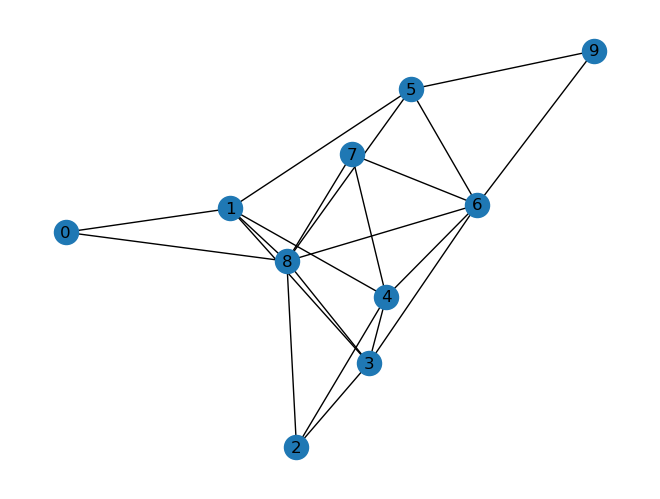

In [18]:
while True:
  G = nx.erdos_renyi_graph(10, 0.3)
  if nx.is_connected(G):
    break
pos = nx.spring_layout(G)
print(pos)
nx.draw(G, pos, with_labels=True)
plt.show()

In [19]:
color_dict = {
    0: 'r',    # Red
    1: 'b',    # Blue
    2: 'g',    # Green
    3: 'c',    # Cyan
    4: 'm',    # Magenta
    5: 'y',    # Yellow
    6: 'k',    # Black
    7: 'orange',
    8: 'purple',
    9: 'brown',
    10: 'pink'
}

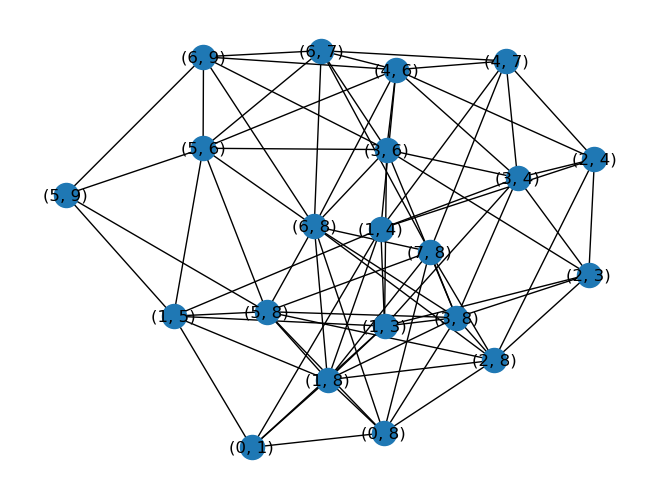

In [20]:
F = nx.line_graph(G)
pos2 = nx.spring_layout(F)
nx.draw(F, pos2, with_labels=True)
plt.show()

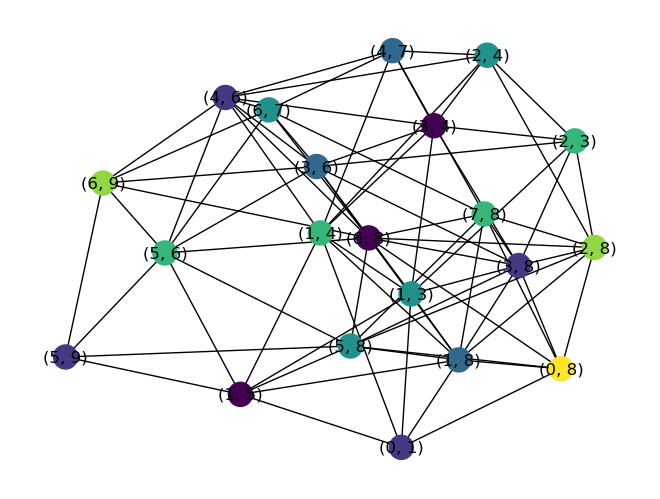

Number of colors needed 7
The maximum degree of the graph is 7


In [21]:
edges_to_colors = nx.coloring.greedy_color(F, strategy="largest_first")
color_map_nodes = []
color_map_edges = []
for node in F:
  color_map_nodes.append(edges_to_colors[node])

for edge in G.edges():
  color_map_edges.append(edges_to_colors[edge])
pos2 = nx.spring_layout(F)
nx.draw(F, pos2, with_labels=True, node_color=color_map_nodes)
plt.show()
max_degree = max(dict(G.degree()).values())
print(f"Number of colors needed {max([x for x in color_map_nodes]) + 1}")
print(f"The maximum degree of the graph is {max_degree}")


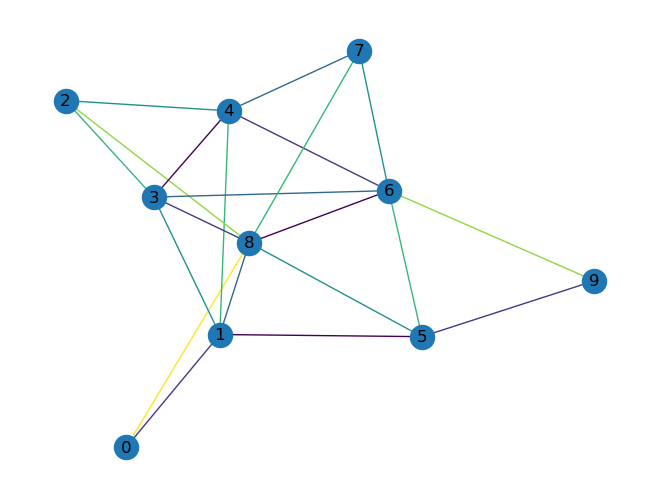

In [22]:
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color=color_map_edges)
plt.show()

In [28]:
# Group edges by color
edges_by_color = {}
for edge, color in edges_to_colors.items():
    if color not in edges_by_color:
        edges_by_color[color] = []
    edges_by_color[color].append(edge)

# Create and visualize each subgraph for each color
subgraphs = {}
laplacians = {}

for color, edges in edges_by_color.items():
    # Create a new subgraph with all nodes from G but only the selected edges
    subgraph = nx.Graph()
    subgraph.add_nodes_from(G.nodes())  # Add all nodes
    subgraph.add_edges_from(edges)      # Add only edges of this color
    subgraphs[color] = subgraph
    # Calculate the Laplacian matrix for the subgraph
    laplacian_matrix = nx.laplacian_matrix(subgraph).toarray()
    laplacians[color] = laplacian_matrix

# Example to print details
for color, subgraph in subgraphs.items():
    print(f"Subgraph for color {color}:")
    print("Nodes:", subgraph.nodes())
    print("Edges:", subgraph.edges())

Subgraph for color 0:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(1, 5), (3, 4), (6, 8)]
Subgraph for color 1:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(0, 1), (3, 8), (4, 6), (5, 9)]
Subgraph for color 2:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(1, 8), (3, 6), (4, 7)]
Subgraph for color 3:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(1, 3), (2, 4), (5, 8), (6, 7)]
Subgraph for color 4:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(1, 4), (2, 3), (5, 6), (7, 8)]
Subgraph for color 5:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(2, 8), (6, 9)]
Subgraph for color 6:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Edges: [(0, 8)]


In [30]:
laplacians[1]

array([[ 1, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  1,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, -1],
       [ 0,  0,  0,  0, -1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  0,  0,  1]], dtype=int32)